In [1]:
# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

# Torchvision libraries
from torchvision import datasets, models, transforms
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights

# Other libraries
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import os
import copy
import random

# Sklearn metrics for evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

## ResNet-50 Architecture

The **ResNet-50 architecture** is a deep convolutional neural network with 50 layers, designed to improve accuracy and efficiency over shallower networks like ResNet-34. The primary difference in ResNet-50 is the use of a **bottleneck block**, which stacks three layers instead of two, allowing for deeper networks without excessive computational load. This modification enables more efficient training by reducing the time needed for layers to converge. ResNet-50 achieves approximately **3.8 billion floating-point operations (FLOPS)**, making it more accurate than ResNet-34.

### ResNet-101 and ResNet-152 Architectures

To create even deeper networks, **ResNet-101** and **ResNet-152** extend the architecture by adding more of these three-layer bottleneck blocks. For example:
- **ResNet-152** has 152 layers and achieves around **11.3 billion FLOPS**, yet remains less complex than traditional models like **VGG-16** and **VGG-19**, which have 15.3 billion and 19.6 billion FLOPS, respectively. This allows for deeper, more powerful models with manageable computational demands.

### Key Concepts in ResNet Architectures

#### Residual Learning

One of the core innovations of ResNet is its approach to **residual learning**. ResNet was designed to address the **vanishing gradient problem**, a challenge in training deep neural networks, by introducing **skip connections** (or shortcut connections). These connections allow gradients to bypass certain layers, facilitating the training of very deep networks. The gradient can pass through the network more effectively, which reduces issues related to training deeper models.

#### Residual Blocks

The **residual blocks** in ResNet architecture are central to its performance. Each residual block takes the output from a previous layer, adds it to the output of the next block, and passes this summed output to the following block. This structure enables ResNet to achieve **state-of-the-art performance** on various image recognition tasks, demonstrating the power of deep residual networks in computer vision applications.

---

This architecture has made ResNet a popular choice in computer vision tasks, from image classification to object detection, providing a robust framework for building and training deep networks effectively.

![ResNet Architecture](https://miro.medium.com/v2/resize:fit:1236/format:webp/1*P5vr-XHZwLUrnRSnaacCkQ.png)

## EfficientNet: A Balanced and Scalable Neural Network Architecture

EfficientNet is a family of neural network architectures that aim to balance **accuracy** and **computational efficiency**, introduced by Google AI in 2019. The core concept behind EfficientNet is a systematic approach to scaling up model architectures by balancing three main factors: **depth, width, and resolution**.

---

### Key Concepts

### 1. Compound Scaling
- Traditional methods to improve model accuracy focus on increasing either the network’s **depth** (more layers), **width** (more channels per layer), or **input resolution**.
- EfficientNet introduces a **compound scaling** method, which scales all three dimensions **uniformly** based on a fixed set of scaling coefficients.
- This approach leads to a balanced model that is both efficient and powerful. As illustrated in the graph, EfficientNet models achieve higher accuracy than other architectures for a similar number of parameters.

### 2. The EfficientNet Family
- The EfficientNet models are labeled as **B0, B1, B2, ... up to B7**, with each successive model scaled up using compound scaling.
- **EfficientNet-B0** serves as the baseline, and each subsequent model increases in network **depth**, **width**, and **resolution** according to the compound scaling coefficients.

---

### Performance Comparison

The graph shows EfficientNet’s performance relative to other popular architectures on the **ImageNet Top-1 Accuracy** benchmark:

- **EfficientNet-B7** achieves a Top-1 accuracy of **84.4%** with **66 million parameters**, outperforming most other models at this level of accuracy.
- Models like **EfficientNet-B4** and **EfficientNet-B5** deliver high accuracy with fewer parameters, making them efficient alternatives to other large models, such as **ResNeXt-101** and **NASNet-A**.
- **EfficientNet-B1** matches the accuracy of **ResNet-152** but uses far fewer parameters (7.8 million vs. 60 million).

---

### Advantages of EfficientNet

- **High Accuracy with Fewer Parameters**: EfficientNet models achieve high accuracy while requiring significantly fewer parameters compared to competing architectures.
- **Balanced Scaling**: By scaling width, depth, and resolution together, EfficientNet models avoid the inefficiencies associated with scaling only one dimension.
- **Flexibility Across Applications**: With various versions (B0-B7), EfficientNet offers flexibility for diverse applications, from mobile devices to large-scale data centers.

---

### Notable Model Variants in the Graph

- **EfficientNet-B3**: Achieves **81.1%** accuracy with only **12 million** parameters, offering a compact model with strong performance.
- **EfficientNet-B4**: Reaches **82.6%** accuracy with **19 million** parameters, balancing efficiency and accuracy.
- **EfficientNet-B7**: The most powerful model in the EfficientNet family, with **84.4%** accuracy and **66 million** parameters, suitable for tasks requiring high precision.

---

EfficientNet’s compound scaling approach has set a new standard in model design by achieving an optimal balance of accuracy and computational efficiency, making it a preferred choice in various image recognition tasks.


![EfficientNet](http://blog.roboflow.com/content/images/2024/04/image-1085.webp)

In [2]:
# Define directories (update these paths if necessary)
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

### Data Transformations for Model Training, Validation, and Testing

To improve the model's ability to generalize and learn robust features, a series of transformations are applied to the images before feeding them into the model. These transformations differ slightly for training, validation, and test sets to optimize the model’s performance in each phase.

### Training Transformations

The transformations for the training set include multiple augmentation techniques designed to increase data variability. This helps prevent overfitting and enables the model to learn invariant features. Here’s a breakdown of the transformations:

- **Resize**: Images are resized to 224x224 pixels to standardize input size and match the model’s input requirements.
- **Random Horizontal Flip**: This flips images horizontally with a certain probability, making the model invariant to the orientation of features.
- **Random Rotation**: Images are randomly rotated up to 20 degrees to help the model learn features regardless of orientation.
- **Color Jitter**: Adjustments in brightness, contrast, saturation, and hue introduce color variations, helping the model learn color-invariant features.
- **Random Grayscale**: A small proportion of images are converted to grayscale, allowing the model to focus on texture and shape rather than color.
- **Gaussian Blur**: Blurs the image with a randomly chosen kernel and sigma, helping the model learn to ignore fine noise and focus on essential features.
- **ToTensor**: Converts the image to a tensor, which is the required format for PyTorch models.
- **Normalize**: Standardizes the image’s color channels using mean and standard deviation values. This ensures consistent pixel intensity ranges across the dataset.

### Validation Transformations

The validation set transformations are kept minimal to provide an unbiased evaluation of the model’s performance on data without extensive augmentations. These transformations include:

- **Resize**: Resizes images to 224x224 pixels to match the training data.
- **Center Crop**: Crops the image at the center, ensuring a consistent view across all validation images.
- **ToTensor**: Converts the image to a tensor format for model input.
- **Normalize**: Standardizes the image color channels to maintain consistency with the training data.

### Test Transformations

The test set transformations are identical to the validation set, ensuring that the model’s final evaluation is based on unaltered data. This allows for an accurate assessment of the model's generalization to new, unseen data. The steps include resizing, center cropping, tensor conversion, and normalization.

### Summary

These transformations help the model learn effectively by:
- Increasing diversity in the training set through augmentations.
- Ensuring consistent input size and color normalization across all sets.
- Providing unbiased validation and testing environments to accurately assess model performance.

By carefully selecting these transformations, the model is better equipped to learn generalized features that enhance its ability to perform well on unseen data.

In [3]:
# Define transformations for training, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomGrayscale(p=0.1),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
# Load datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, transform=data_transforms['val']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

In [5]:
# Create data loaders with num_workers set to 0 to avoid multiprocessing issues
batch_size = 32
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True, num_workers=0),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False, num_workers=0)
}

In [6]:
# Get dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
class_names

['NORMAL', 'PNEUMONIA']

In [7]:
# Load EfficientNet-B7 with pre-trained weights
model = efficientnet_b7(weights=EfficientNet_B7_Weights.IMAGENET1K_V1)

# Freeze most layers and add dropout in the classifier
for param in model.parameters():
    param.requires_grad = False
for param in model.features[6:].parameters():  # Unfreeze the last two blocks
    param.requires_grad = True

# Modify the classifier to fit the number of classes and increase dropout
num_ftrs = model.classifier[1].in_features  # Get the input features of the final layer
model.classifier = nn.Sequential(
    nn.Dropout(0.5),      # Dropout layer for regularization
    nn.Linear(num_ftrs, 512),  # Add an intermediate layer with 512 units
    nn.ReLU(),                 # Activation function
    nn.Dropout(0.3),      # Another dropout layer
    nn.Linear(512, 2)     # Final layer for binary classification
)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 195MB/s]


In [8]:
# Define the loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Define optimizer with increased weight decay
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=5e-4)  # Increased weight decay

# Cosine annealing scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Early stopping and checkpoint parameters
patience = 5
epochs_without_improvement = 0
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

### Training Loop with Gradient Accumulation

This training loop is designed for efficient optimization in cases where hardware memory limits may restrict batch size. It uses **gradient accumulation** to simulate a larger batch size, which can improve model convergence. Here’s a breakdown of how it works:

### Key Components

- **Epochs**: The loop is set to run for a specified number of epochs (in this case, 50), where each epoch is a complete pass over the training dataset.
- **Gradient Accumulation**: Instead of updating the model’s weights after each batch, gradients are accumulated over multiple batches (4 in this case). This simulates a larger effective batch size, reducing memory requirements while preserving the benefits of larger batches.
- **Loss Tracking**: During training, both training and validation losses are recorded to monitor model performance.

### Phases

1. **Training Phase**:
   - For each batch, images and labels are loaded onto the device (CPU or GPU).
   - A **forward pass** is performed to calculate the model’s output and the **loss**.
   - The loss is divided by the accumulation steps to normalize it, which prevents the gradients from becoming too large.
   - A **backward pass** computes the gradients, but they are not immediately applied.
   - After every 4 batches, the optimizer updates the model's weights, and the gradients are reset. This prevents frequent updates and simulates a larger batch size.

2. **Validation Phase**:
   - The model is set to evaluation mode, and validation loss is calculated without updating model weights.
   - Validation loss is tracked for early stopping purposes.

### Early Stopping
- Early stopping is used to prevent overfitting. If the validation loss does not improve for a specified number of epochs (`patience`), training is stopped early.
- The model’s weights are saved whenever there’s an improvement in validation loss, ensuring that the best-performing model is retained.

### Learning Rate Scheduler
- A scheduler gradually reduces the learning rate, helping the model converge more effectively by allowing finer adjustments as training progresses.

### Final Model
- After training, the best model weights (based on the lowest validation loss) are loaded for further evaluation or deployment.

This training loop balances efficiency and model performance by using gradient accumulation, early stopping, and learning rate scheduling, making it suitable for complex models and large datasets.

In [9]:
# Training loop with gradient accumulation
num_epochs = 100
accumulation_steps = 4  # Accumulate gradients over 4 batches
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Training phase
    for i, (images, labels) in enumerate(tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{num_epochs}")):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass and loss calculation
        outputs = model(images)
        loss = criterion(outputs, labels) / accumulation_steps  # Normalize loss by accumulation steps

        # Backward pass
        loss.backward()
        
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()  # Update weights after accumulation_steps
            optimizer.zero_grad()

        running_loss += loss.item() * labels.size(0)

    train_loss = running_loss / dataset_sizes['train']
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in dataloaders['val']:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * labels.size(0)
    
    val_loss = val_running_loss / dataset_sizes['val']
    val_losses.append(val_loss)
    
    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement == patience:
            print("Early stopping triggered.")
            break

    # Step the scheduler
    scheduler.step()

    # Print losses every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

# Load best model weights
model.load_state_dict(best_model_wts)

Epoch 9/100: 100%|██████████| 163/163 [02:55<00:00,  1.07s/it]


Early stopping triggered.


<All keys matched successfully>

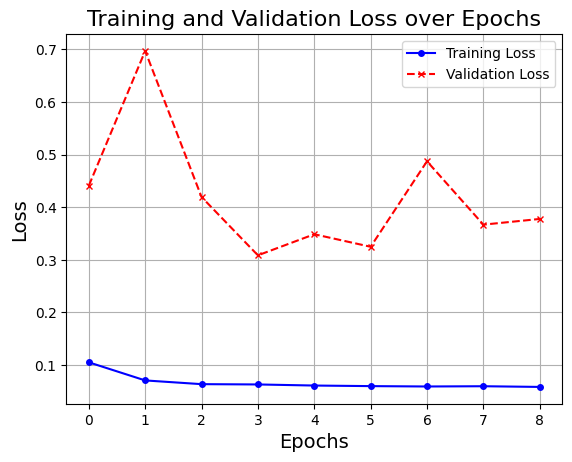

In [10]:
# Plot training and validation loss
plt.plot(train_losses, label='Training Loss', color='blue', linestyle='-', marker='o', markersize=4)
plt.plot(val_losses, label='Validation Loss', color='red', linestyle='--', marker='x', markersize=4)

# Add title and labels
plt.title('Training and Validation Loss over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Show legend
plt.legend()

# Add grid for better readability
plt.grid(True)
plt.show()

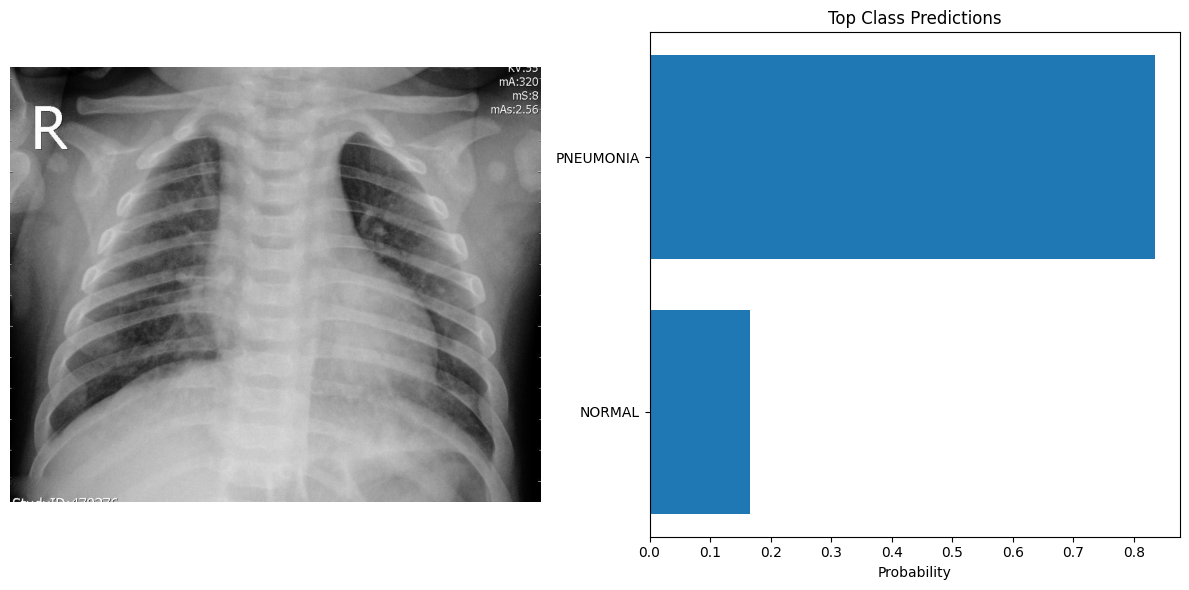

Image 1:
  Actual class: PNEUMONIA
  Predicted class: PNEUMONIA
------------------------------


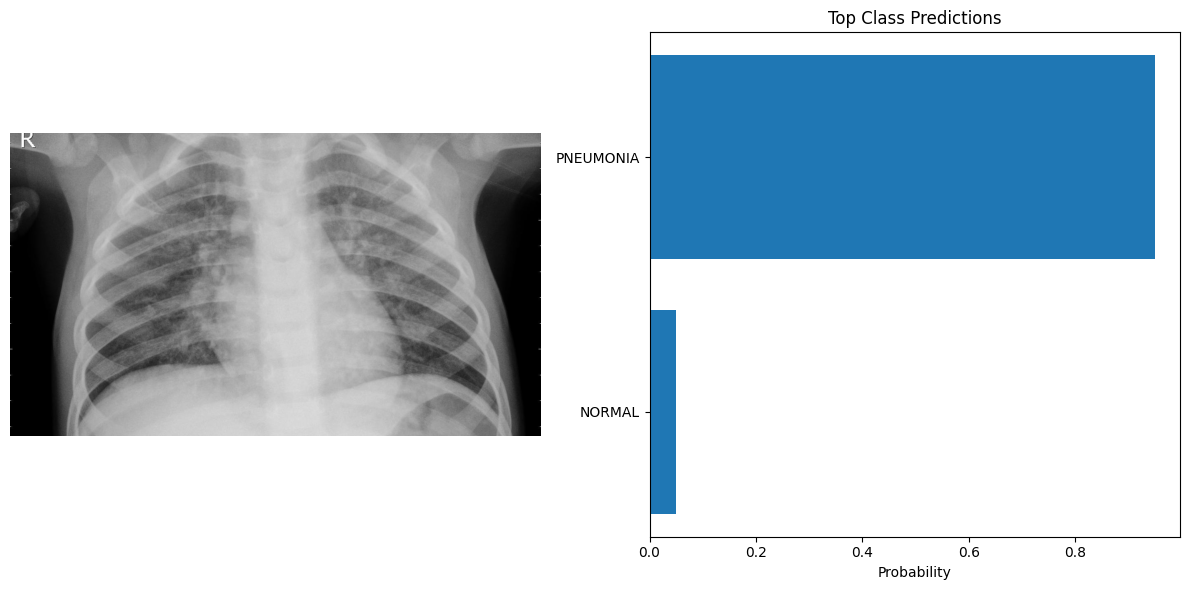

Image 2:
  Actual class: PNEUMONIA
  Predicted class: PNEUMONIA
------------------------------


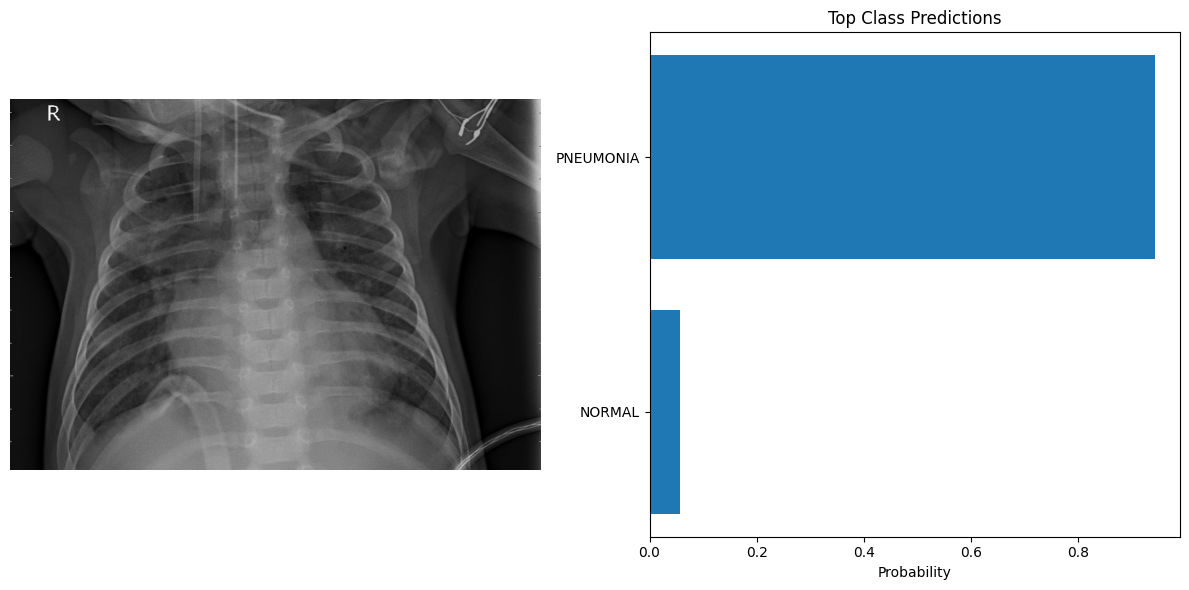

Image 3:
  Actual class: PNEUMONIA
  Predicted class: PNEUMONIA
------------------------------


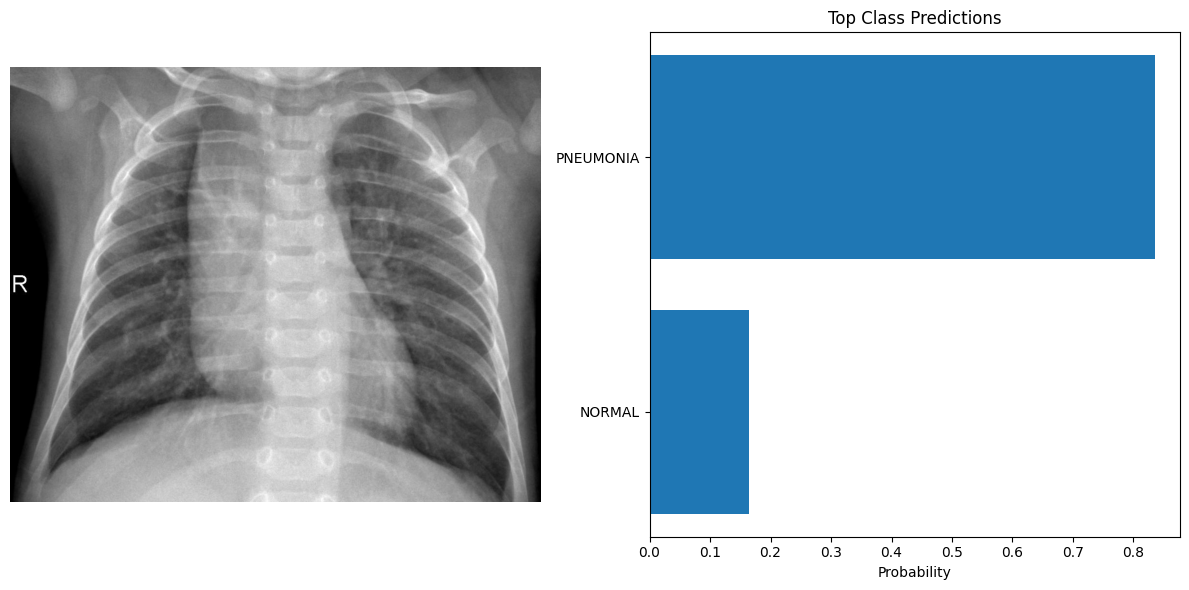

Image 4:
  Actual class: NORMAL
  Predicted class: PNEUMONIA
------------------------------


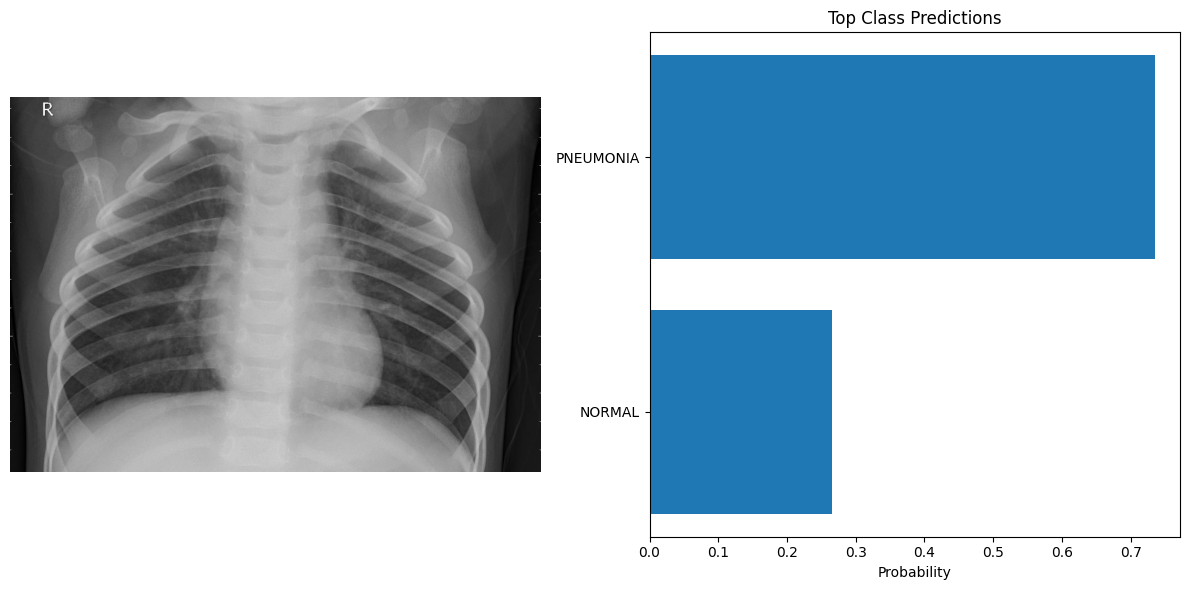

Image 5:
  Actual class: NORMAL
  Predicted class: PNEUMONIA
------------------------------


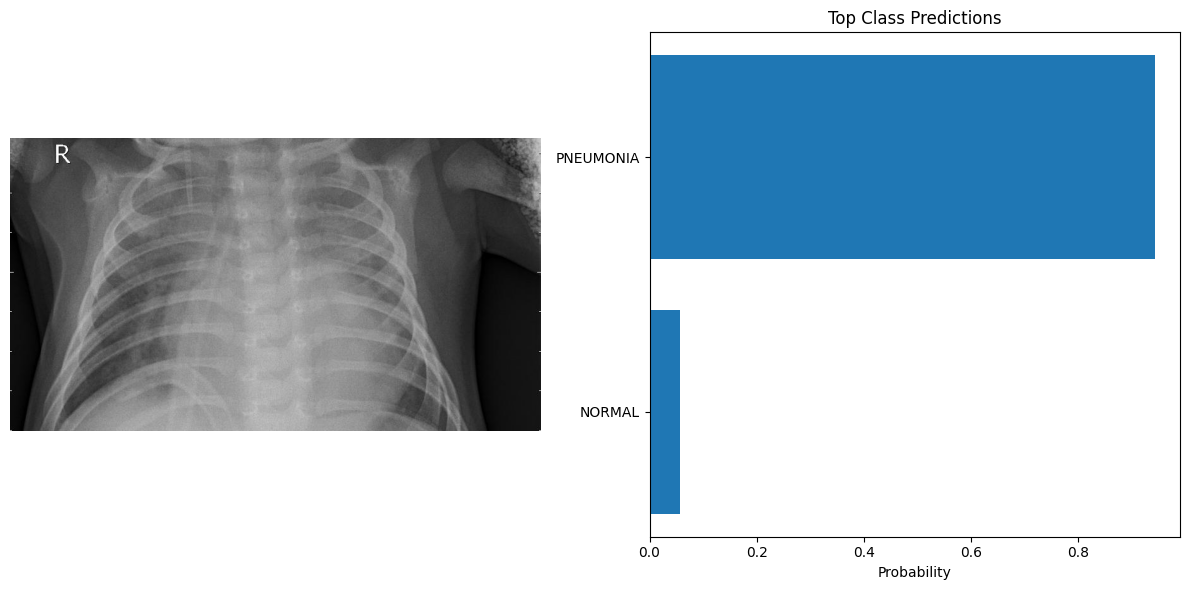

Image 6:
  Actual class: PNEUMONIA
  Predicted class: PNEUMONIA
------------------------------


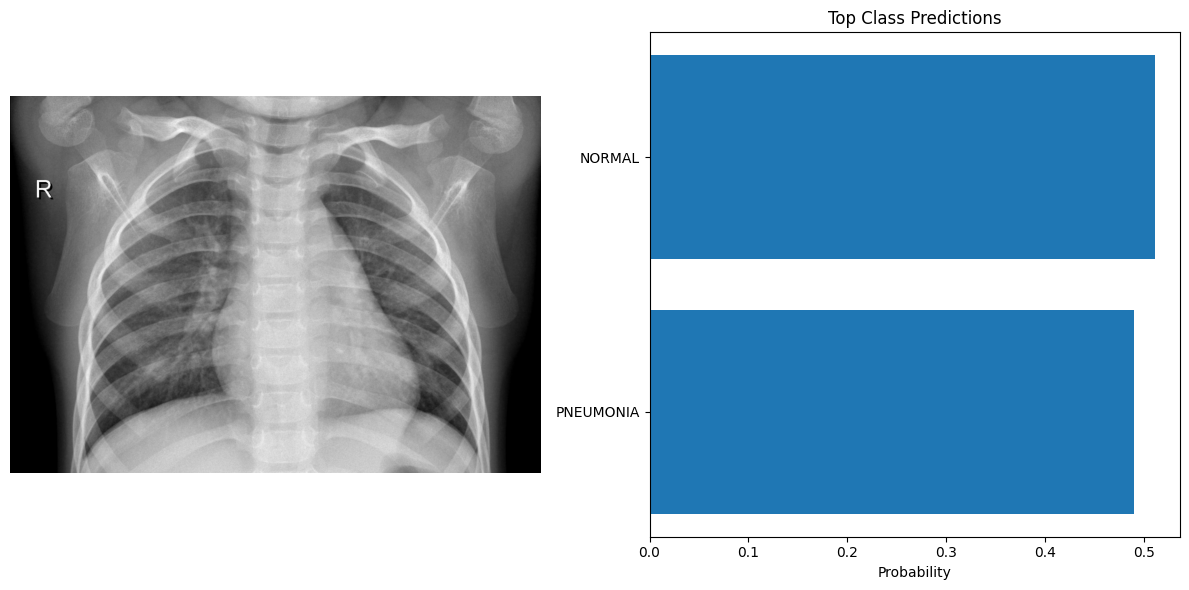

Image 7:
  Actual class: NORMAL
  Predicted class: NORMAL
------------------------------


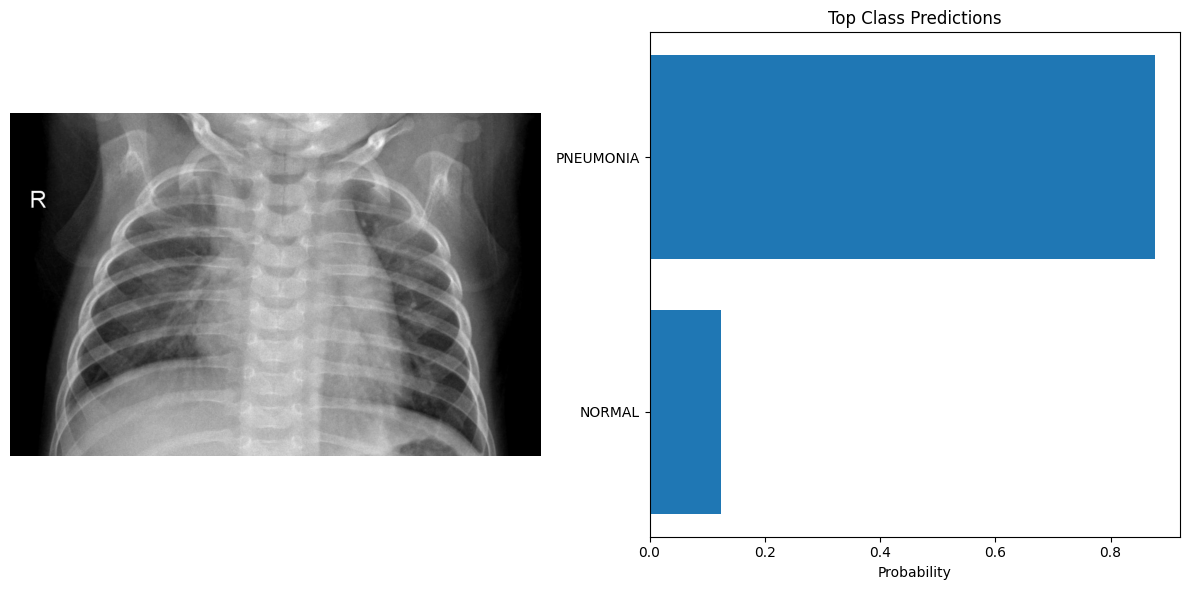

Image 8:
  Actual class: PNEUMONIA
  Predicted class: PNEUMONIA
------------------------------


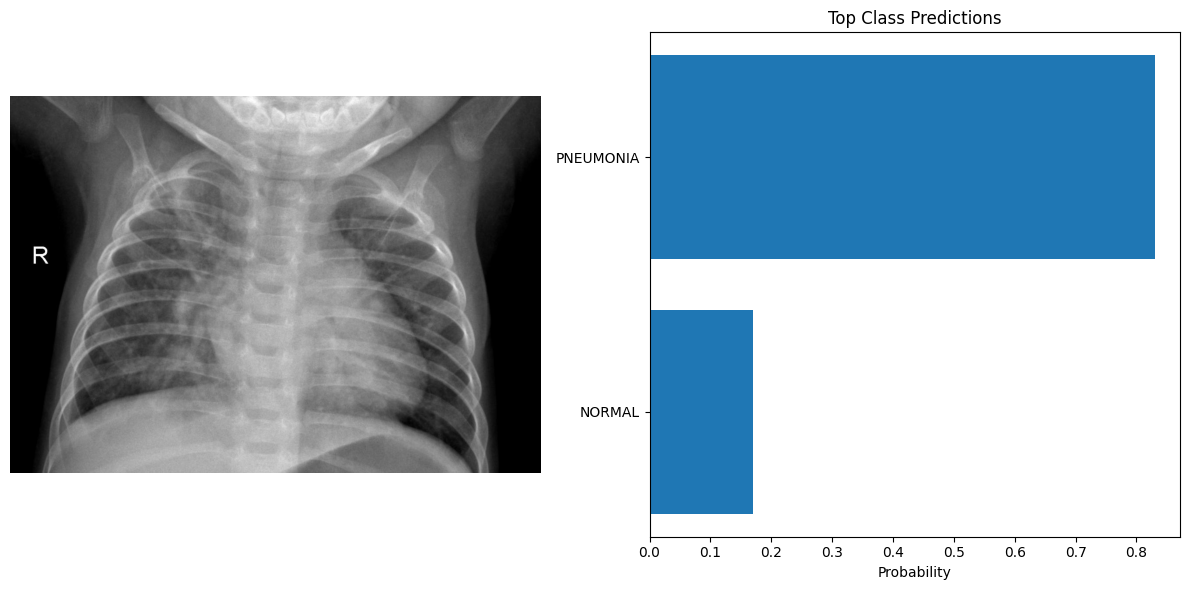

Image 9:
  Actual class: PNEUMONIA
  Predicted class: PNEUMONIA
------------------------------


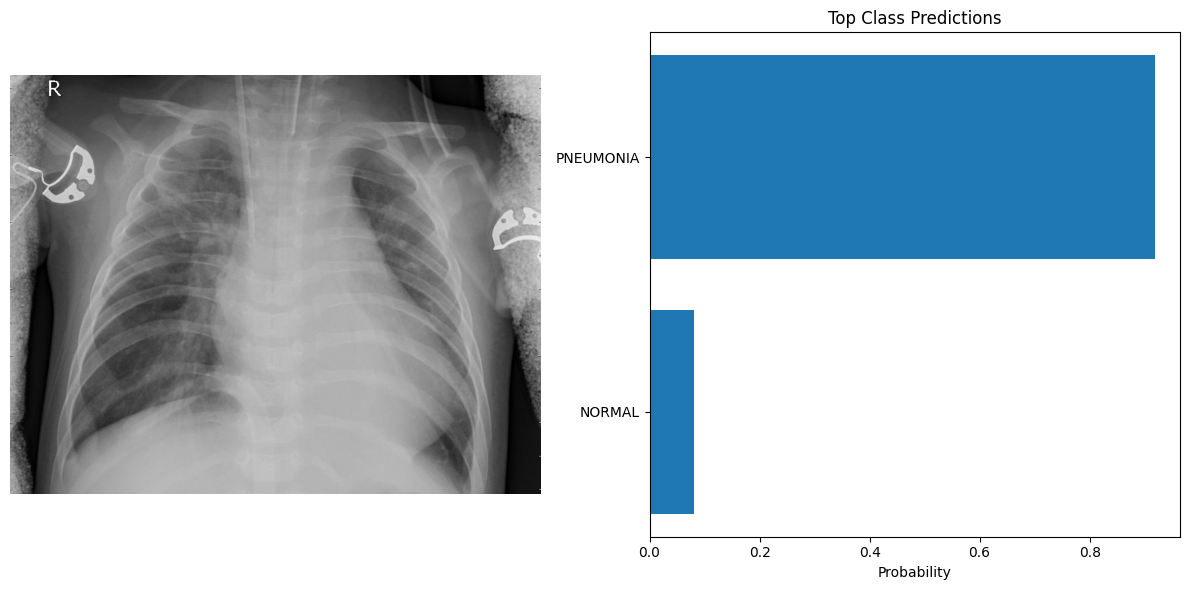

Image 10:
  Actual class: PNEUMONIA
  Predicted class: PNEUMONIA
------------------------------


In [11]:
# Function to load and preprocess an image
def load_and_preprocess_image(image_path, transform):
    """
    Loads an image from the specified path, converts it to RGB format, applies transformations, 
    and prepares it as a tensor for model input.
    
    Args:
        image_path (str): The file path of the image to load.
        transform (torchvision.transforms.Compose): Transformations to apply to the image.
        
    Returns:
        tuple: Original PIL image and preprocessed image tensor ready for model input.
    """
    image = Image.open(image_path).convert("RGB")  # Open and convert image to RGB
    return image, transform(image).unsqueeze(0)     # Apply transformations and add batch dimension


# Prediction function with combined loading, preprocessing, and prediction
def predict_image(model, image_path, transform, device):
    """
    Loads and preprocesses an image, then uses the model to predict class probabilities.
    
    Args:
        model (torch.nn.Module): Trained model to use for prediction.
        image_path (str): Path to the image file to predict.
        transform (torchvision.transforms.Compose): Transformations to apply to the image.
        device (torch.device): Device to run the model on (CPU or GPU).
        
    Returns:
        tuple: Original image and class probabilities as a numpy array.
    """
    original_image, image_tensor = load_and_preprocess_image(image_path, transform)  # Load and preprocess image
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for inference
        image_tensor = image_tensor.to(device)  # Move image tensor to specified device
        outputs = model(image_tensor)           # Get model outputs
        probabilities = F.softmax(outputs, dim=1)  # Apply softmax to get class probabilities
    
    return original_image, probabilities.cpu().numpy().flatten()  # Return image and probabilities


# Visualization function for predictions
def visualize_predictions(image, probabilities, class_names, top_k=2):
    """
    Displays the original image alongside a bar chart of the top-k class predictions.
    
    Args:
        image (PIL.Image): The original image.
        probabilities (np.array): Array of class probabilities output by the model.
        class_names (list): List of class names corresponding to model output.
        top_k (int): Number of top predictions to display (default is 2 for binary classification).
    """
    top_k_idx = probabilities.argsort()[-top_k:][::-1]         # Get indices of top-k predictions
    top_classes = [class_names[i] for i in top_k_idx]          # Retrieve class names for top-k predictions
    top_probabilities = probabilities[top_k_idx]               # Get probabilities for top-k predictions

    # Plotting the original image and top-k predictions
    fig, axarr = plt.subplots(1, 2, figsize=(12, 6))
    axarr[0].imshow(image)                                     # Display the original image
    axarr[0].axis("off")
    
    axarr[1].barh(top_classes, top_probabilities)              # Display bar chart for top-k predictions
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Top Class Predictions")
    axarr[1].invert_yaxis()                                    # Display highest probability at the top
    
    plt.tight_layout()
    plt.show()


# Function to select a random image from the test folder
def get_random_image_from_folder(folder_path):
    """
    Selects a random image from a specified folder structure where images are organized by class.
    
    Args:
        folder_path (str): Path to the root folder containing subfolders for each class.
        
    Returns:
        tuple: File path to a randomly selected image and the actual class label.
    """
    classes = os.listdir(folder_path)                          # List all class subfolders in the test folder
    random_class = random.choice(classes)                      # Choose a random class
    class_folder = os.path.join(folder_path, random_class)     # Path to chosen class folder
    image_files = os.listdir(class_folder)                     # List all images in the chosen class folder
    random_image_file = random.choice(image_files)             # Choose a random image from the class folder
    return os.path.join(class_folder, random_image_file), random_class  # Return image path and class


# Example usage to predict and visualize 10 random images
test_folder_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"  # Path to your test data
transform = transforms.Compose([
    transforms.Resize((224, 224)),    # Resize images to match model input size
    transforms.ToTensor(),            # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize as per ImageNet standards
])

class_names = ["NORMAL", "PNEUMONIA"]  # Set class names for binary classification

# Loop to predict on 10 random images and visualize results
for i in range(10):  
    test_image_path, actual_class = get_random_image_from_folder(test_folder_path)  # Select random image
    original_image, probabilities = predict_image(model, test_image_path, transform, device)  # Make prediction
    visualize_predictions(original_image, probabilities, class_names)  # Visualize top predictions
    
    # Print actual and predicted class
    predicted_class_idx = probabilities.argmax()
    predicted_class = class_names[predicted_class_idx]
    print(f"Image {i+1}:")
    print(f"  Actual class: {actual_class}")
    print(f"  Predicted class: {predicted_class}")
    print("-" * 30)

### Model Evaluation Metrics and Confusion Matrix Analysis

### Metrics

1. **Test Accuracy: 85.8974%**
   - The model correctly classified 85.9% of the test images. Accuracy is the ratio of correct predictions to the total number of predictions.

2. **Precision: 0.8240**
   - Precision indicates the proportion of positive predictions that are correct. Here, the model's precision is 82.4%, meaning that when it predicts the positive class (e.g., "PNEUMONIA"), 82.4% of those predictions are correct.
   - **Formula**:
     $$ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} $$

3. **Recall: 0.9846**
   - Recall represents the proportion of actual positive cases that were correctly identified. A recall of 98.5% means that 98.5% of the actual positive cases (e.g., "PNEUMONIA") were correctly classified as positive.
   - **Formula**:
     $$ \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} $$

4. **F1 Score: 0.8972**
   - The F1 Score is the harmonic mean of precision and recall, balancing both metrics. A high F1 Score indicates a good balance between precision and recall, which is useful in cases with imbalanced data.
   - **Formula**:
     $$ \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$
   - In this case, an F1 Score of 89.7% reflects a good balance between identifying true positives and avoiding false positives.

### Confusion Matrix
The confusion matrix provides a detailed breakdown of the model’s performance across the two classes:

$$
\begin{bmatrix} 152 & 82 \\ 6 & 384 \end{bmatrix}
$$

- **True Negatives (152)**: The model correctly identified 152 instances of the negative class (e.g., "NORMAL").
- **False Positives (82)**: The model incorrectly identified 82 instances as positive (e.g., "PNEUMONIA") when they were actually negative ("NORMAL").
- **False Negatives (6)**: The model incorrectly classified 6 positive instances (e.g., "PNEUMONIA") as negative ("NORMAL").
- **True Positives (384)**: The model correctly identified 384 instances of the positive class (e.g., "PNEUMONIA").

### Interpretation

- **High Recall (98.5%)**: The model is highly sensitive to identifying positive cases ("PNEUMONIA"), which is crucial in medical applications where missing positive cases could have serious consequences.
- **Moderate Precision (82.4%)**: The model has a fair number of false positives, meaning it sometimes incorrectly labels "NORMAL" cases as "PNEUMONIA".
- **Overall Balance**: With an F1 Score of 89.7%, the model shows a reasonable balance between precision and recall, making it reliable for detecting positive cases with minimal risk of missing them.

This analysis suggests that while the model is highly effective at detecting positive cases (high recall), some improvements could be made to increase precision and reduce false positives, especially if over-diagnosis is a concern.


Test Accuracy: 83.8141%
Precision: 0.7992
Recall: 0.9897
F1 Score: 0.8843
Confusion Matrix:
[[137  97]
 [  4 386]]


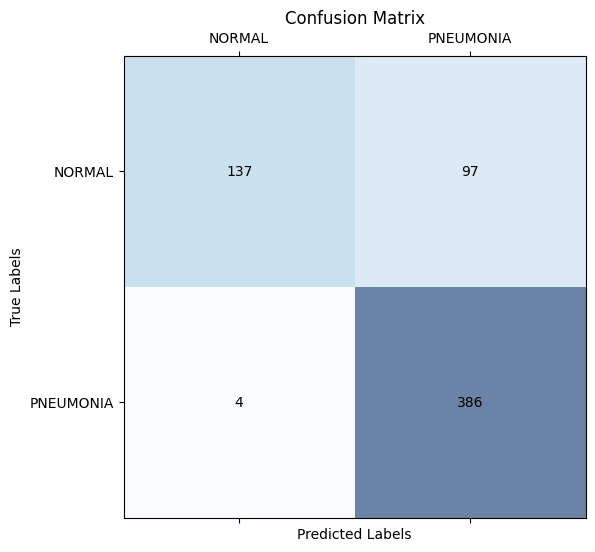

In [12]:
# Define enhanced evaluation function
def evaluate_model(model, dataloader, class_names):
    model.eval()  # Set model to evaluation mode
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            
            # Collect all predictions and labels for detailed metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = running_corrects.double() / len(dataloader.dataset) * 100
    print(f'Test Accuracy: {accuracy:.4f}%')

    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    # Display confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Optionally, visualize the confusion matrix
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.6)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(ticks=[0, 1], labels=class_names)
    plt.yticks(ticks=[0, 1], labels=class_names)
    plt.show()

# Example usage:
class_names = ["NORMAL", "PNEUMONIA"]  # Define your class names
evaluate_model(model, dataloaders['test'], class_names)